![title](notebook_images/logo.png)

# Facial Recognition
---
Facial biometrics is one of the most widely used biometric technologies, largely due to its ease of deployment and implementation, as well as the fact that it doesn't require physical interaction from the user. The three main application areas for facial recognition systems are:

- **Security and law enforcement**: Used to locate missing children or disoriented adults, and to identify or track criminals.
- **Healthcare**: Applied in the detection of genetic disorders, pain management, and monitoring responses to medication.
- **Banking and retail**: With the rise of the digital era, facial recognition has become increasingly popular due to its convenience, providing secure, touch-free interactions. Banking systems often incorporate liveness detection to prevent hackers from using static images to impersonate users.

Any facial recognition system typically involves the following steps:

1. **Face detection**: Identifying faces in a given image.
2. **Feature extraction**: Extracting feature vector descriptors from the raw face image.
3. **Face matching**: Using the extracted features for verification or identification.

Facial recognition systems can be implemented using various techniques, including Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP), and deep learning. The first three are classic computer vision methods that remain relevant today. All four approaches generate feature vector descriptors that can be used for verification or identification purposes.


This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    


## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties.

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=c6ced48fa153e6f7311623b08d2c660523c0754f8a8e8ed35d8572eb692a645e
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module.
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

* [The CALTECH Faces dataset](https://data.caltech.edu/records/6rjah-hdv18) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data.

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn.


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm
* target: N-dimensional vector of labels

In [4]:
# size of each face after preprocessing
face_size=(47, 47)

In [5]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1


    return gray, imagePath.parent.name

# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("/kaggle/input/face-recognition-data/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully
# Please note that 5 images were removed from the original set, because
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [6]:
import pandas as pd
import cv2
from pathlib import Path
import os

def read_img(imagePath):
    # Load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # Extract the label from the image path
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1

    return gray, imagePath.parent.name

# Grab all the image paths associated with the faces in the subdirectories
datasetPath = Path("/kaggle/input/face-recognition-data/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# Read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]

# Create a DataFrame from the images and labels
df = pd.DataFrame(imgs, columns=['images', 'target'])

# Check if all images were found successfully
# Please note that 5 images were removed from the original set,
# because they wouldn't match the corresponding individual.
assert len(df) == 445

# Define the file path where you want to save the Excel file
file_path = '/kaggle/working/dataframe.xlsx'

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the DataFrame to an Excel file
df.to_excel(file_path, index=False)


In [7]:
unique_persons = df['target'].nunique()
print(f"Number of unique persons in the DataFrame: {unique_persons}")

Number of unique persons in the DataFrame: 26


### 2. Inspect some images

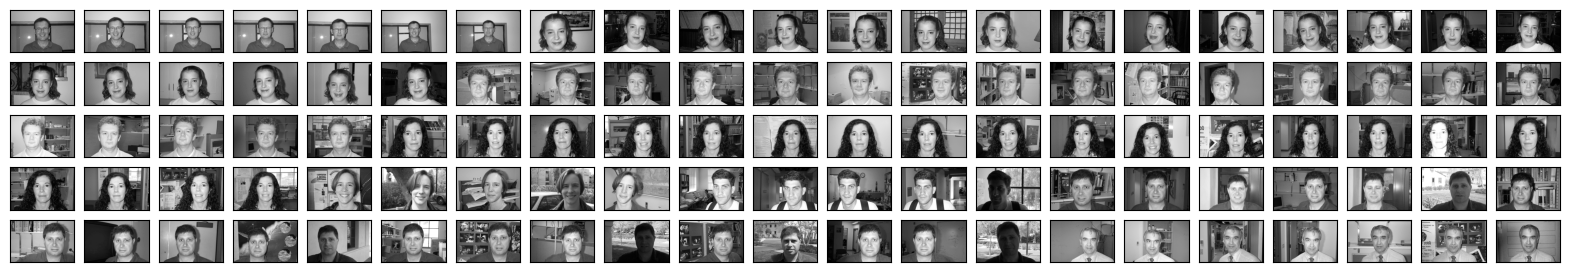

In [8]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Shape of the first image: (592, 896)


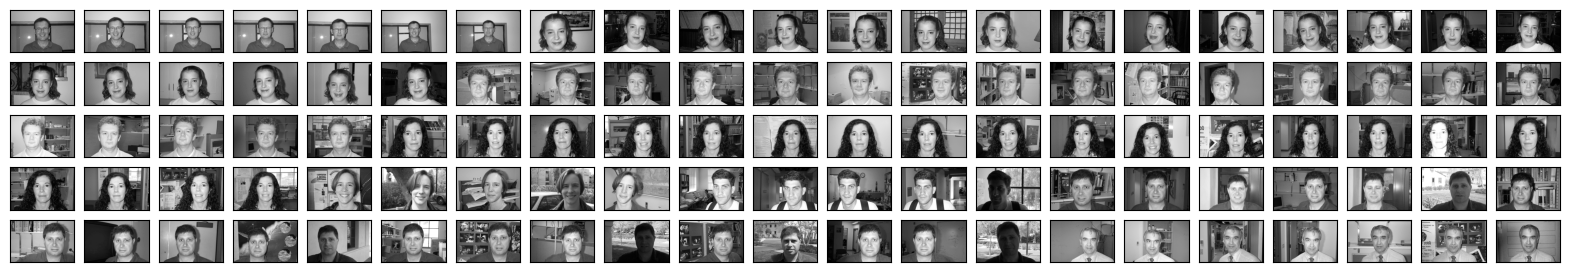

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Assuming data['images'] contains the images before flattening

# Verify the shape of the first image
first_image_shape = data['images'][0].shape
print(f"Shape of the first image: {first_image_shape}")

# Create a figure and image grid
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),  # Adjust grid size if needed
                 axes_pad=0.1,
                 )

# Display the images in the grid
for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes.

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1).

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this work we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [11]:
faceCascade = cv2.CascadeClassifier('/kaggle/input/face-recognition-data/models/haarcascade_frontalface_default.xml')

In [12]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()

        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()

        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data),
              images     = np.array(images),
              labels     = np.array(labels),
              target     = np.array(targets))

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch

# Assuming faces is a Bunch with data (feature vectors), images (actual images), labels (person identifiers), and target (numeric labels or similar identifiers)
data = faces['data']
images = faces['images']
labels = faces['labels']

# Map each unique label to an integer
unique_person_ids = np.unique(labels)
label_to_index = {label: idx for idx, label in enumerate(unique_person_ids)}

# Function to map labels to indices
def map_labels_to_indices(labels_array):
    return np.array([label_to_index[label] for label in labels_array])

# Prepare containers for the split datasets
reference_data = []
reference_images = []
reference_labels = []
verification_data = []
verification_images = []
verification_labels = []

# Iterate over each unique person in the dataset
for person_id in unique_person_ids:
    # Find all indices of images for the current person
    person_indices = np.where(labels == person_id)[0]
    # Split these indices into reference and verification sets
    ref_indices, ver_indices = train_test_split(person_indices, test_size=0.25, random_state=42)
    
    # Append data to the respective lists
    reference_data.append(data[ref_indices])
    reference_images.append(images[ref_indices])
    reference_labels.append(labels[ref_indices])
    
    verification_data.append(data[ver_indices])
    verification_images.append(images[ver_indices])
    verification_labels.append(labels[ver_indices])

# Flatten the lists (since they are lists of arrays)
reference_data = np.concatenate(reference_data)
reference_images = np.concatenate(reference_images)
reference_labels = np.concatenate(reference_labels)

verification_data = np.concatenate(verification_data)
verification_images = np.concatenate(verification_images)
verification_labels = np.concatenate(verification_labels)

# Convert labels in reference and verification sets to indices
reference_targets = map_labels_to_indices(reference_labels)
verification_targets = map_labels_to_indices(verification_labels)

# Create Bunch objects for reference and verification sets
faces_reference = Bunch(data=reference_data, images=reference_images, labels=reference_labels, target=reference_targets)
faces_verification = Bunch(data=verification_data, images=verification_images, labels=verification_labels, target=verification_targets)


In [14]:
print(faces_reference)

{'data': array([[251, 249, 252, ...,  48, 124, 164],
       [172, 165, 121, ...,  32,  48,  67],
       [133, 136, 135, ..., 109,  78,  73],
       ...,
       [ 70,  21,  31, ...,  33,  64,  72],
       [ 50,  23,  22, ..., 147, 148, 147],
       [ 50,  54,  21, ...,  96,  94, 100]], dtype=uint8), 'images': array([[[[251],
         [249],
         [252],
         ...,
         [ 63],
         [138],
         [179]],

        [[254],
         [254],
         [249],
         ...,
         [ 53],
         [ 86],
         [219]],

        [[247],
         [254],
         [243],
         ...,
         [ 78],
         [ 52],
         [191]],

        ...,

        [[203],
         [191],
         [186],
         ...,
         [159],
         [169],
         [178]],

        [[196],
         [208],
         [210],
         ...,
         [ 69],
         [180],
         [176]],

        [[189],
         [185],
         [191],
         ...,
         [ 48],
         [124],
         [164]]],


  

In [15]:
import numpy as np

# Assuming 'labels' is a numpy array with labels corresponding to each image
original_counts = np.unique(faces['labels'], return_counts=True)
print("Image count per person in the original dataset:")
for person_id, count in zip(*original_counts):
    print(f"{person_id}: {count} images")


Image count per person in the original dataset:
person_001: 20 images
person_002: 20 images
person_003: 5 images
person_004: 23 images
person_005: 20 images
person_006: 23 images
person_007: 20 images
person_008: 4 images
person_009: 21 images
person_010: 7 images
person_011: 6 images
person_012: 5 images
person_013: 18 images
person_014: 21 images
person_015: 25 images
person_016: 23 images
person_017: 4 images
person_018: 21 images
person_019: 18 images
person_020: 26 images
person_021: 20 images
person_022: 20 images
person_023: 22 images
person_024: 5 images
person_025: 21 images
person_026: 22 images


In [16]:
# Assuming 'labels' in faces_reference is a numpy array with labels corresponding to each image
reference_counts = np.unique(faces_reference['labels'], return_counts=True)
print("Image count per person in the reference dataset:")
for person_id, count in zip(*reference_counts):
    print(f"{person_id}: {count} images")


Image count per person in the reference dataset:
person_001: 15 images
person_002: 15 images
person_003: 3 images
person_004: 17 images
person_005: 15 images
person_006: 17 images
person_007: 15 images
person_008: 3 images
person_009: 15 images
person_010: 5 images
person_011: 4 images
person_012: 3 images
person_013: 13 images
person_014: 15 images
person_015: 18 images
person_016: 17 images
person_017: 3 images
person_018: 15 images
person_019: 13 images
person_020: 19 images
person_021: 15 images
person_022: 15 images
person_023: 16 images
person_024: 3 images
person_025: 15 images
person_026: 16 images


In [17]:
# Assuming 'labels' in faces_verification is a numpy array with labels corresponding to each image
verification_counts = np.unique(faces_verification['labels'], return_counts=True)
print("Image count per person in the verification dataset:")
for person_id, count in zip(*verification_counts):
    print(f"{person_id}: {count} images")


Image count per person in the verification dataset:
person_001: 5 images
person_002: 5 images
person_003: 2 images
person_004: 6 images
person_005: 5 images
person_006: 6 images
person_007: 5 images
person_008: 1 images
person_009: 6 images
person_010: 2 images
person_011: 2 images
person_012: 2 images
person_013: 5 images
person_014: 6 images
person_015: 7 images
person_016: 6 images
person_017: 1 images
person_018: 6 images
person_019: 5 images
person_020: 7 images
person_021: 5 images
person_022: 5 images
person_023: 6 images
person_024: 2 images
person_025: 6 images
person_026: 6 images


In [17]:
print(faces_reference['data'].shape)

(320, 2209)


In [20]:
print(faces['target'].shape)

(440,)


In [21]:
print(faces['data'].shape)

(440, 2209)


In [22]:
display(faces['data'][0].shape)

(2209,)

In [23]:
import numpy as np

# Calculate the original size of the image
flattened_size = 2209
original_size = int(np.sqrt(flattened_size))
print(f"Original size of the image: {original_size} x {original_size}")


Original size of the image: 47 x 47


### 2. Print statistics of data

In [24]:
# extract number of samples and image dimensions (for later display)
# n_samples, h, w, n_channels = faces.images.shape
n_samples, h, w, n_channels = faces.images.shape

imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces_reference.target.max() +1

n_features = faces_reference.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

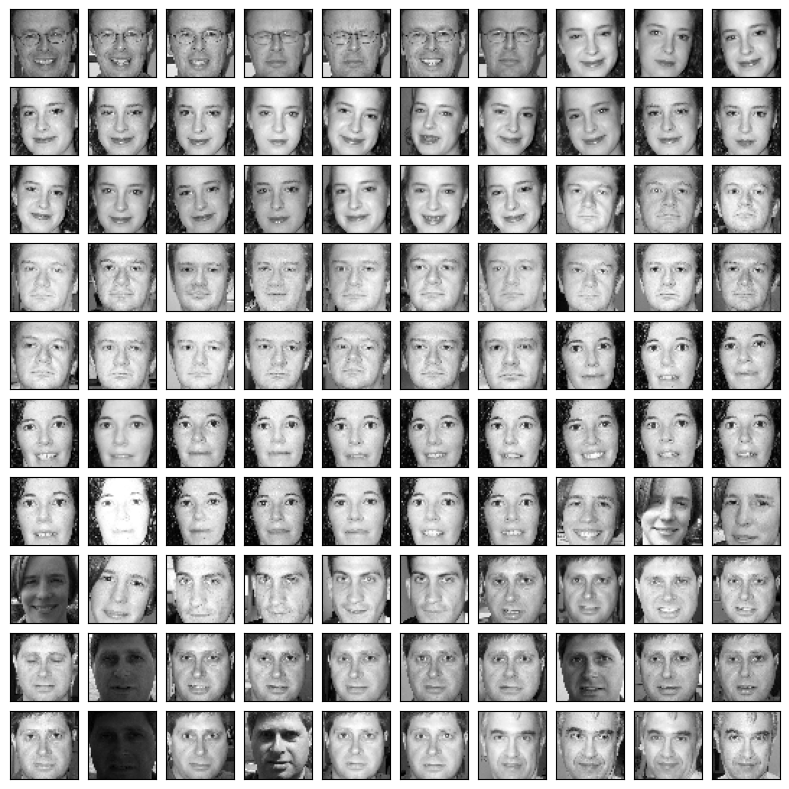

In [25]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping.

In [26]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True,
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion?

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition.

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [27]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca

    dist_metric = euclidean

In [28]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import numpy as np



# Set num_components
num_components = 35



# Compute a PCA (eigenfaces) on the face dataset
num_components = min(num_components, min(n_samples, n_features))
print("num_components {n}".format(n=num_components))

desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces_reference.data)
X_pca = desc.transform(faces_reference.data)
embedded_PCA = X_pca

# Print the transformed data
print("embedded_PCA (transformed data):")
print(embedded_PCA)
print("Shape of embedded_PCA:", embedded_PCA.shape)

# Define the distance metric
dist_metric = euclidean


num_components 35
embedded_PCA (transformed data):
[[ 3.06460238  1.96706478  0.10368122 ...  1.17546121 -0.24671219
  -0.78136493]
 [ 2.66536408  1.4958494  -0.59418769 ...  1.02483974 -0.88120989
  -1.105874  ]
 [-0.24599223 -0.25825611  0.33003493 ... -0.2187644   1.24454579
   0.41950593]
 ...
 [-1.18428701 -1.00106792 -0.45863097 ...  0.88144549  0.32135096
   1.18939496]
 [-0.56210001  0.45418481  1.38740335 ...  1.56415586  0.56812437
   1.14817321]
 [-0.37196931 -0.33256267  0.71580425 ...  0.84929316  0.45566536
  -0.10810586]]
Shape of embedded_PCA: (320, 35)


In [29]:
from sklearn.decomposition import PCA
import numpy as np

# Assuming faces_reference.data is your reference dataset and faces_verification.data is your verification dataset
reference_data = faces_reference.data
verification_data = faces_verification.data

# Initialize PCA, number of components should be chosen based on variance you want to retain
pca = PCA(n_components=35, whiten=True, svd_solver='randomized')

# Fit PCA on the reference dataset
pca.fit(reference_data)

# Transform both reference and verification datasets
embedded_reference = pca.transform(reference_data)
embedded_verification = pca.transform(verification_data)

# Now both datasets are projected into the same PCA space
# embedded_reference and embedded_verification can be used to compare and compute distances


In [30]:
from scipy.spatial.distance import cdist

# Compute the distance matrix
distance_matrix_PCA = cdist(embedded_verification, embedded_reference, 'euclidean')

# Now, distance_matrix[i, j] holds the Euclidean distance between i-th verification sample and j-th reference sample



In [31]:
print(distance_matrix_PCA.shape)

(120, 320)


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).



In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda

    dist_metric = euclidean

In [33]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean
import numpy as np

# Dummy data to simulate the face dataset
np.random.seed(0)
n_samples = 440
n_features = 2209
n_classes = 26


# Set num_components
num_components = 35

# Compute LDA on the face dataset
num_components = min(num_components, min(n_classes - 1, n_features))
print("num_components {n}".format(n=num_components))

desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces_reference.data, faces_reference.target)
X_lda = desc.transform(faces_reference.data)
embedded_LDA = X_lda

# Print the transformed data
print("embedded_LDA (transformed data):")
print(embedded_LDA)
print("Shape of embedded_LDA:", embedded_LDA.shape)

# Define the distance metric
dist_metric = euclidean


num_components 25
embedded_LDA (transformed data):
[[ 1.26181874  1.32175737  1.3887082  ...  0.26872734  1.52234228
   1.11272753]
 [ 2.75422287 -1.37668159  6.70740501 ...  1.93089211 -0.39766514
   0.6966296 ]
 [ 0.10701422 -0.80800793  4.11830772 ...  0.99666591 -0.06710488
  -0.56558338]
 ...
 [-3.45463755 -0.60241319  3.21195602 ...  0.14573545  0.90877484
  -0.11131099]
 [-3.80038816 -0.29582759  1.57784282 ...  1.37872857  0.61522871
   0.89100743]
 [-4.22738918 -2.42151298  2.2567459  ...  1.8786805  -0.19856785
  -1.40203669]]
Shape of embedded_LDA: (320, 25)


In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean
import numpy as np

# Assuming `faces_reference` and `faces_verification` are already defined and contain 'data' and 'target'

# Set the number of components for LDA
num_components = 35  # This should be at most min(n_classes - 1, n_features)
n_classes = len(np.unique(faces_reference.target))  # Adjust based on the actual number of unique labels
num_components = min(num_components, n_classes - 1)

# Initialize and fit LDA on the reference set
desc = LinearDiscriminantAnalysis(n_components=num_components)
desc.fit(faces_reference.data, faces_reference.target)
embedded_LDA_reference = desc.transform(faces_reference.data)

# Transform the verification set using the same LDA model
embedded_LDA_verification = desc.transform(faces_verification.data)

# Print the transformed data
print("Embedded LDA Reference (transformed data):")
print(embedded_LDA_reference)
print("Shape of Embedded LDA Reference:", embedded_LDA_reference.shape)

print("Embedded LDA Verification (transformed data):")
print(embedded_LDA_verification)
print("Shape of Embedded LDA Verification:", embedded_LDA_verification.shape)

# Define the distance metric (assuming use for comparison later)
dist_metric = euclidean


Embedded LDA Reference (transformed data):
[[ 1.26181874  1.32175737  1.3887082  ...  0.26872734  1.52234228
   1.11272753]
 [ 2.75422287 -1.37668159  6.70740501 ...  1.93089211 -0.39766514
   0.6966296 ]
 [ 0.10701422 -0.80800793  4.11830772 ...  0.99666591 -0.06710488
  -0.56558338]
 ...
 [-3.45463755 -0.60241319  3.21195602 ...  0.14573545  0.90877484
  -0.11131099]
 [-3.80038816 -0.29582759  1.57784282 ...  1.37872857  0.61522871
   0.89100743]
 [-4.22738918 -2.42151298  2.2567459  ...  1.8786805  -0.19856785
  -1.40203669]]
Shape of Embedded LDA Reference: (320, 25)
Embedded LDA Verification (transformed data):
[[ 1.59930708 -0.32484293  3.9035557  ...  0.82253932  0.8976127
   1.05729066]
 [ 3.68075292  3.14222346  0.53040618 ... -0.89783757  3.28078161
  -0.40568864]
 [ 1.30474164  2.19736747  3.88601507 ...  1.12493912  1.10269586
  -0.8281342 ]
 ...
 [-2.75580735 -1.43906289  2.94239913 ...  1.05273521 -0.17663412
   1.10398968]
 [-1.98372542 -0.38735686  2.09276777 ... -0.942

In [35]:
# Assuming dist_metric is the Euclidean distance
from scipy.spatial.distance import cdist

# Compute the distance matrix between the embedded data of reference and verification sets
distance_matrix_LDA = cdist(embedded_LDA_verification, embedded_LDA_reference, metric='euclidean')

# Print the distance matrix
print("Distance Matrix:")
print(distance_matrix_LDA)
print("Shape of Distance Matrix:", distance_matrix_LDA.shape)


Distance Matrix:
[[ 8.8854223   6.42282152  6.06268537 ... 12.30875056 13.09007238
  14.00469234]
 [11.1859306  11.73705583 10.81926529 ... 16.08224309 16.37838268
  17.50511925]
 [ 7.18148449  8.62806161 11.66602382 ... 12.75456751 13.58142627
  13.74691394]
 ...
 [12.71222196 12.68180639 14.91289015 ...  5.36164088  5.59958754
   6.75178025]
 [11.61703501 13.62557195 15.63413486 ...  6.72680502  7.0763308
   7.17897934]
 [12.99258083 14.27866751 15.62938696 ...  5.26644329  5.18065657
   6.80493271]]
Shape of Distance Matrix: (120, 320)


some optimizations

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.


In [36]:
import sys
sys.path.append('/kaggle/input/face-recognition-data/localmodules')

from local_binary_patterns import LBP
from scipy.stats import chisquare
import numpy as np

# Define the FeatureDescriptor class with LBP attribute
class FeatureDescriptor:
    LBP = "LBP"

# Assign DESC directly for this example
DESC = FeatureDescriptor.LBP

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])

    dist_metric = chisquare

# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d


In [37]:
from local_binary_patterns import LBP
from scipy.stats import chisquare

# Set up LBP descriptor and compute the embeddings
desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
embedded_LBP = desc.describe_list(faces_reference.images[..., 0])

# Print the transformed data
print("embedded_LBP (transformed data):")
print(embedded_LBP)
print("Shape of embedded_LBP:", embedded_LBP.shape)

# Define the distance metric
dist_metric = chisquare

# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:
def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

# Example usage of CHI2 function
distance = CHI2(embedded_LBP[0], embedded_LBP[1])
print("Chi-Squared distance between first two samples:", distance)


embedded_LBP (transformed data):
[[0.08333333 0.13888889 0.08333333 ... 0.13888889 0.05555556 0.27777778]
 [0.13888889 0.05555556 0.05555556 ... 0.08333333 0.08333333 0.02777778]
 [0.02777778 0.11111111 0.11111111 ... 0.02777778 0.05555556 0.08333333]
 ...
 [0.13888889 0.11111111 0.08333333 ... 0.02777778 0.02777778 0.02777778]
 [0.13888889 0.11111111 0.05555556 ... 0.05555556 0.11111111 0.08333333]
 [0.11111111 0.16666667 0.11111111 ... 0.02777778 0.08333333 0.05555556]]
Shape of embedded_LBP: (320, 490)
Chi-Squared distance between first two samples: 6.242733833360828


In [38]:
import sys
sys.path.append('/kaggle/input/face-recognition-data/localmodules')

from local_binary_patterns import LBP
import numpy as np

# Define the FeatureDescriptor class with LBP attribute
class FeatureDescriptor:
    LBP = "LBP"

# Assign DESC directly for this example
DESC = FeatureDescriptor.LBP

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_LBP_reference = desc.describe_list(faces_reference.images[..., 0])
    embedded_LBP_verification = desc.describe_list(faces_verification.images[..., 0])

    # Print the transformed data
    print("embedded_LBP Reference (transformed data):")
    print(embedded_LBP_reference)
    print("Shape of embedded_LBP Reference:", embedded_LBP_reference.shape)
    
    print("embedded_LBP Verification (transformed data):")
    print(embedded_LBP_verification)
    print("Shape of embedded_LBP Verification:", embedded_LBP_verification.shape)

    # Define the distance metric using a safe chi-squared function
    def CHI2(histA, histB, eps=1e-10):
        # Compute the chi-squared distance
        d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
        return d

    # Compute distance matrix between reference and verification sets
    from scipy.spatial.distance import cdist

    distance_matrix_LBP = cdist(embedded_LBP_verification, embedded_LBP_reference, metric=lambda a, b: CHI2(a, b))
    print("Distance Matrix LBP between Verification and Reference:")
    print(distance_matrix_LBP)
    print("Shape of distance_matrix_LBP:", distance_matrix_LBP.shape)


embedded_LBP Reference (transformed data):
[[0.08333333 0.13888889 0.08333333 ... 0.13888889 0.05555556 0.27777778]
 [0.13888889 0.05555556 0.05555556 ... 0.08333333 0.08333333 0.02777778]
 [0.02777778 0.11111111 0.11111111 ... 0.02777778 0.05555556 0.08333333]
 ...
 [0.13888889 0.11111111 0.08333333 ... 0.02777778 0.02777778 0.02777778]
 [0.13888889 0.11111111 0.05555556 ... 0.05555556 0.11111111 0.08333333]
 [0.11111111 0.16666667 0.11111111 ... 0.02777778 0.08333333 0.05555556]]
Shape of embedded_LBP Reference: (320, 490)
embedded_LBP Verification (transformed data):
[[0.16666667 0.11111111 0.02777778 ... 0.         0.         0.        ]
 [0.13888889 0.13888889 0.05555556 ... 0.08333333 0.11111111 0.22222222]
 [0.08333333 0.19444444 0.05555556 ... 0.         0.11111111 0.16666667]
 ...
 [0.11111111 0.16666667 0.08333333 ... 0.05555556 0.         0.02777778]
 [0.05555556 0.13888889 0.05555556 ... 0.02777778 0.05555556 0.08333333]
 [0.11111111 0.02777778 0.16666667 ... 0.05555556 0.0

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms.
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics.

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification.
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations.
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br>

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function.
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large.







There is a very elegant Python implementation available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface.

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough.

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [39]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import siamese as siamese

#some older versions may need this
import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow.keras import backend as K

encoder, model = siamese.create_siamese_model(imshape, num_components)
model.summary()

2024-10-17 06:19:04.710995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 06:19:04.711139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 06:19:04.866656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 47, 47, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 47, 47, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 25)        │    235,097 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 235,097 (918.35 KB)

 Trainable params: 235,097 (918.35 KB)

 Non-trainable params: 0 (0.00 B)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [43]:
import siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

# Example data preparation function - modify as per your actual setup
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces_reference.images, faces_reference.target))

# Define optimizer
rms = Adam()

# Compile the model with the Siamese architecture specifics
model.compile(
    loss=siamese.contrastive_loss,
    optimizer=rms,
    metrics=[siamese.accuracy],
    run_eagerly=True
)

# Set the number of epochs for training
epochs = 20

# Train the model on the reference set
model.fit([x_train[:, 0], x_train[:, 1]], y_train,
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

# Test the model using the test split from the reference set
test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))

# Use the trained model's encoder to project the verification set
embedded_DL_reference = encoder(faces_reference.images.astype(np.float32)).numpy()
embedded_DL_verification = encoder(faces_verification.images.astype(np.float32)).numpy()

print("Shape of embedded_DL Reference:", embedded_DL_reference.shape)
print("Shape of embedded_DL Verification:", embedded_DL_verification.shape)

# Compute the Euclidean distance matrix between the embedded verification and reference sets
distance_matrix_DL = cdist(embedded_DL_verification, embedded_DL_reference, metric='euclidean')
print("Distance Matrix DL between Verification and Reference:")
print(distance_matrix_DL)
print("Shape of distance_matrix_DL:", distance_matrix_DL.shape)


Epoch 1/20
38/38 - 14s - 372ms/step - accuracy: 0.5186 - loss: 0.0034 - val_accuracy: 0.5266 - val_loss: 0.0037
Epoch 2/20
38/38 - 14s - 365ms/step - accuracy: 0.5114 - loss: 0.0020 - val_accuracy: 0.5266 - val_loss: 0.0022
Epoch 3/20
38/38 - 21s - 548ms/step - accuracy: 0.5209 - loss: 9.3325e-04 - val_accuracy: 0.5266 - val_loss: 0.0016
Epoch 4/20
38/38 - 15s - 383ms/step - accuracy: 0.5098 - loss: 6.6082e-04 - val_accuracy: 0.5266 - val_loss: 0.0015
Epoch 5/20
38/38 - 20s - 525ms/step - accuracy: 0.5159 - loss: 5.6863e-04 - val_accuracy: 0.5266 - val_loss: 0.0012
Epoch 6/20
38/38 - 14s - 372ms/step - accuracy: 0.5127 - loss: 3.9952e-04 - val_accuracy: 0.5266 - val_loss: 0.0011
Epoch 7/20
38/38 - 15s - 389ms/step - accuracy: 0.5196 - loss: 4.3178e-04 - val_accuracy: 0.5266 - val_loss: 0.0015
Epoch 8/20
38/38 - 14s - 362ms/step - accuracy: 0.5113 - loss: 6.9051e-04 - val_accuracy: 0.5266 - val_loss: 0.0016
Epoch 9/20
38/38 - 21s - 559ms/step - accuracy: 0.5170 - loss: 7.7502e-04 - val_

## Distance matrix

In [56]:
normalized_distance_matrices = {
    'PCA': distance_matrix_PCA,
    'LDA': distance_matrix_LDA,
    'DL': distance_matrix_DL,
    'LBP': distance_matrix_LBP
}

In [57]:
# Function to perform min-max normalization on a matrix
def min_max_normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val) if max_val > min_val else matrix

In [58]:
# Assuming distance matrices are already normalized
normalized_distance_matrices = {
    'PCA': min_max_normalize_matrix(distance_matrix_PCA),
    'LDA': min_max_normalize_matrix(distance_matrix_LDA),
    'DL': min_max_normalize_matrix(distance_matrix_DL),
    'LBP': min_max_normalize_matrix(distance_matrix_LBP)
}

## 2. Evaluation



### 2.1. Validation as verification system

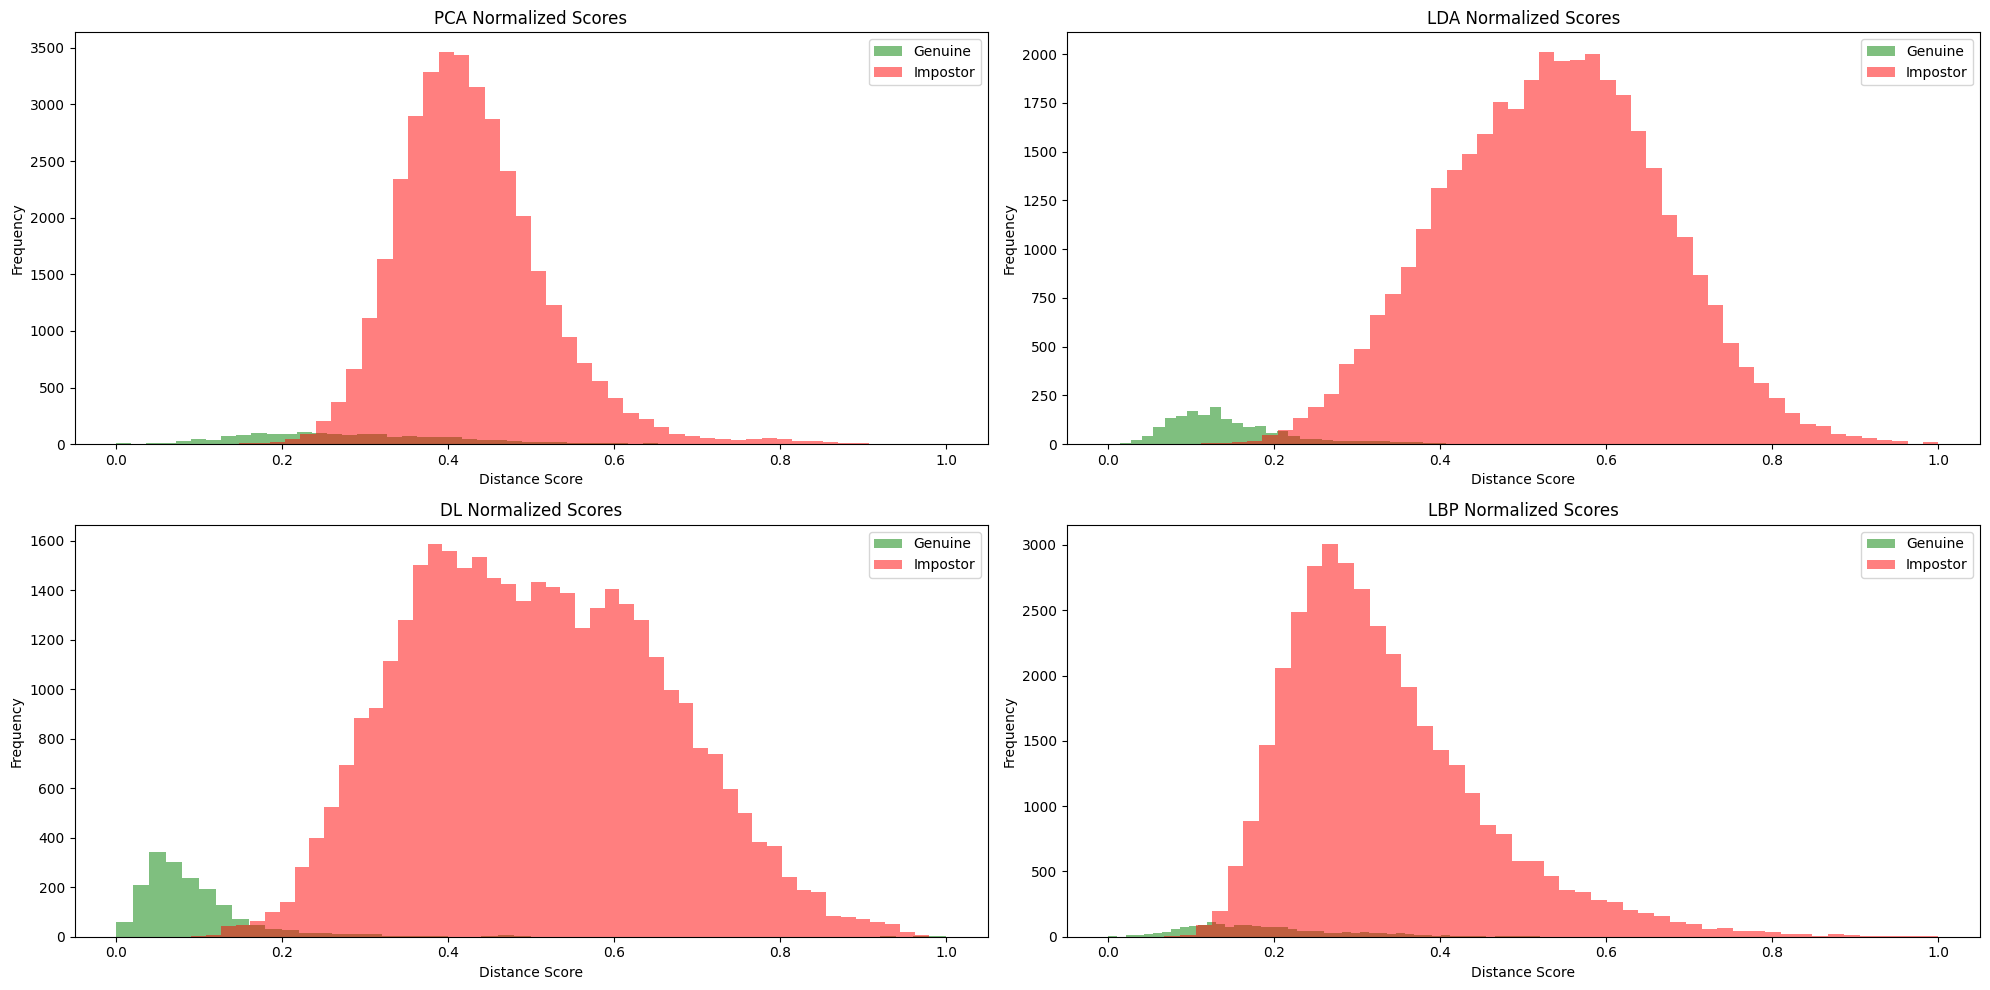

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to separate genuine and impostor scores
def get_genuine_impostor_scores(dist_matrix, labels_reference, labels_verification):
    genuine_scores = []
    impostor_scores = []

    # Iterate over each element in the distance matrix
    for i in range(dist_matrix.shape[0]):        # For each item in verification set
        for j in range(dist_matrix.shape[1]):    # Compare to each item in reference set
            if labels_verification[i] == labels_reference[j]:
                genuine_scores.append(dist_matrix[i, j])
            else:
                impostor_scores.append(dist_matrix[i, j])

    return genuine_scores, impostor_scores


# Extract genuine and impostor scores for each method
scores = {}
for method, dist_matrix in normalized_distance_matrices.items():
    scores[method] = get_genuine_impostor_scores(
        dist_matrix, faces_reference.target, faces_verification.target
    )

# Plotting the genuine and impostor scores
plt.figure(figsize=(20, 10))
for i, (method, (genuine_scores, impostor_scores)) in enumerate(scores.items()):
    plt.subplot(2, 2, i + 1)
    plt.hist(genuine_scores, bins=50, alpha=0.5, color='green', label='Genuine')
    plt.hist(impostor_scores, bins=50, alpha=0.5, color='red', label='Impostor')
    plt.title(f"{method} Normalized Scores")
    plt.xlabel("Distance Score")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/score_distribution_plots.png')  # Save the figure to the working directory
plt.show()


## F1 across thresholds

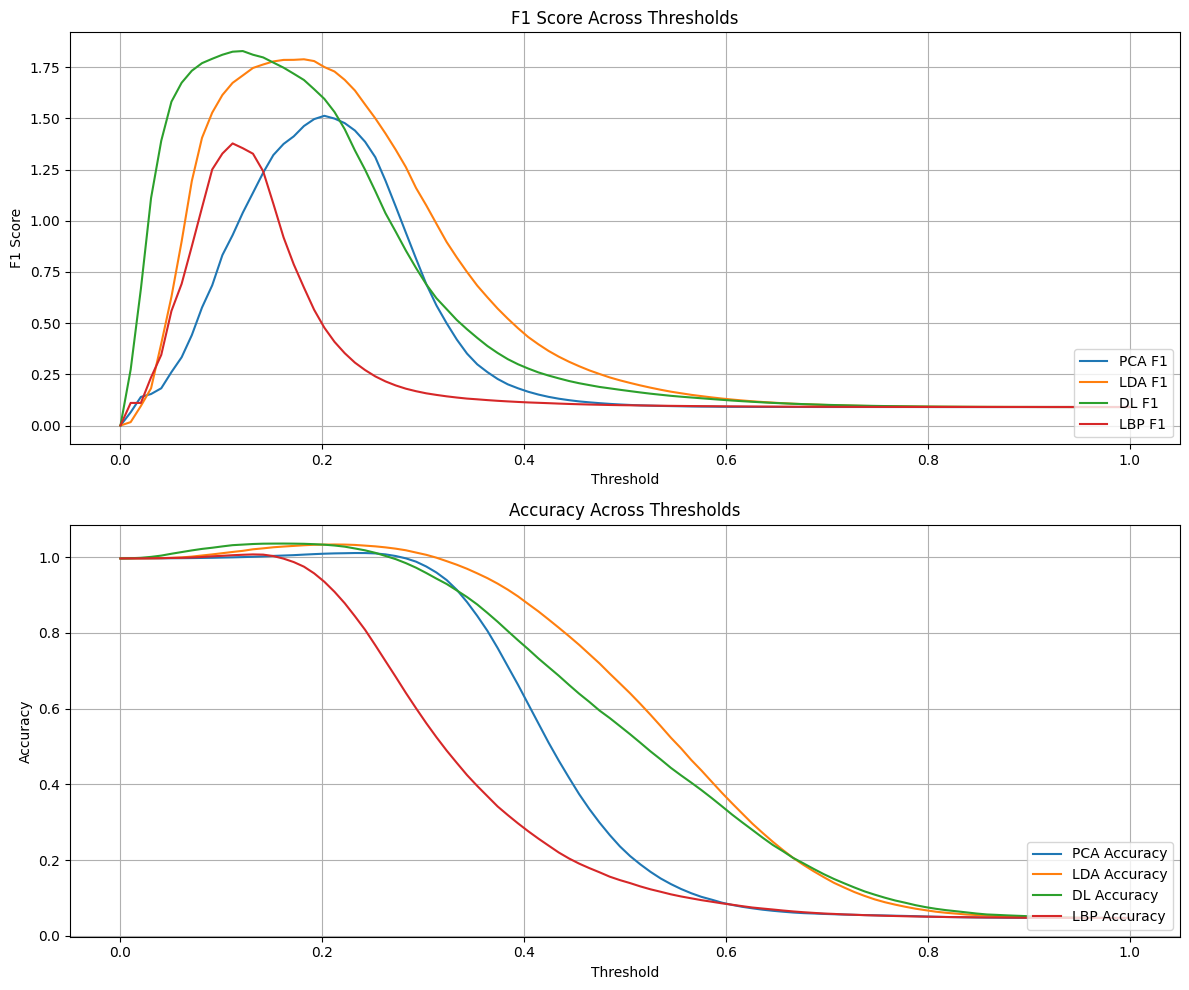

The optimal F1 threshold for PCA is: 0.2020
The optimal F1 threshold for LDA is: 0.1818
The optimal F1 threshold for DL is: 0.1212
The optimal F1 threshold for LBP is: 0.1111


In [60]:
from sklearn.metrics import f1_score, accuracy_score

# Assume distance_matrices is a dictionary containing all the normalized matrices
distance_matrices = {
    'PCA': normalized_distance_matrices['PCA'],
    'LDA': normalized_distance_matrices['LDA'],
    'DL': normalized_distance_matrices['DL'],
    'LBP': normalized_distance_matrices['LBP']
}

def calculate_metrics(dist_matrix, labels_reference, labels_verification, thresholds):
    distances = []
    true_labels = []

    # Flatten the distance matrix and create true labels
    for i in range(dist_matrix.shape[0]):        # For each item in the verification set
        for j in range(dist_matrix.shape[1]):    # Compare to each item in the reference set
            distances.append(dist_matrix[i, j])
            if labels_verification[i] == labels_reference[j]:
                true_labels.append(1)  # Genuine pair
            else:
                true_labels.append(0)  # Impostor pair

    distances = np.array(distances)
    true_labels = np.array(true_labels)

    f1_scores = []
    accuracy_scores = []

    # Calculate F1 score and accuracy for each threshold
    for threshold in thresholds:
        predicted_labels = (distances <= threshold).astype(int)  # Assuming lower distance means more similar
        f1 = f1_score(true_labels, predicted_labels)
        acc = accuracy_score(true_labels, predicted_labels)
        f1_scores.append(f1)
        accuracy_scores.append(acc)

    return np.array(f1_scores), np.array(accuracy_scores)

# Define thresholds to test
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 10))

optimal_thresholds = {}

# Calculate and plot F1 and Accuracy for each system
for key, matrix in distance_matrices.items():
    f1_scores, accuracy_scores = calculate_metrics(matrix, faces_reference.labels, faces_verification.labels, thresholds)
    max_f1_index = np.argmax(f1_scores)
    optimal_thresholds[key] = thresholds[max_f1_index]

    plt.subplot(2, 1, 1)
    plt.plot(thresholds, f1_scores, label=f'{key} F1')
    plt.title('F1 Score Across Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(thresholds, accuracy_scores, label=f'{key} Accuracy')
    plt.title('Accuracy Across Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/metrics_across_thresholds.png')
plt.show()

# Print the optimal F1 thresholds for each system
for system, opt_threshold in optimal_thresholds.items():
    print(f"The optimal F1 threshold for {system} is: {opt_threshold:.4f}")


In [62]:
# Initialize overall counts for all rows
total_TP = 0
total_FP = 0
total_FN = 0

# Access the full PCA distance matrix
distance_matrix = normalized_distance_matrices['PCA']

# Define the distance threshold
threshold = 0.5

# Iterate over each row in the distance matrix and the corresponding label in verification set
for idx, (row_distances, reference_person) in enumerate(zip(distance_matrix, faces_verification.labels)):
    # Initialize counts for the current row
    TP = 0
    FP = 0
    FN = 0

    # Set to keep track of which persons have been checked for FP to avoid duplicates
    unique_persons_checked = set()

    # Determine if a TP has been found to manage FN calculation
    is_TP_found = False

    # Evaluate distances to count TP, FP
    for i, distance in enumerate(row_distances):
        current_person = faces_reference.labels[i]  # Assuming labels are aligned with distances

        # Check if the distance is less than the threshold
        if distance < threshold:
            # If the current distance is for the reference person and a TP hasn't been found yet
            if current_person == reference_person:
                if not is_TP_found:  # Only the first valid match is counted as TP
                    TP += 1
                    is_TP_found = True
            else:
                # For other persons, count as FP but ensure each person is only counted once
                if current_person not in unique_persons_checked:
                    FP += 1
                    unique_persons_checked.add(current_person)

    # If no True Positive match was found for the reference person, count a False Negative
    if not is_TP_found:
        FN += 1

    # Accumulate results for overall totals
    total_TP += TP
    total_FP += FP
    total_FN += FN

    # Optionally print the results for each row
    print(f"Row {idx}: TP = {TP}, FP = {FP}, FN = {FN}")

# Output the overall results
print(f"Overall: TP = {total_TP}, FP = {total_FP}, FN = {total_FN}")


Row 0: TP = 1, FP = 25, FN = 0
Row 1: TP = 1, FP = 11, FN = 0
Row 2: TP = 1, FP = 20, FN = 0
Row 3: TP = 1, FP = 25, FN = 0
Row 4: TP = 1, FP = 25, FN = 0
Row 5: TP = 1, FP = 25, FN = 0
Row 6: TP = 1, FP = 25, FN = 0
Row 7: TP = 1, FP = 25, FN = 0
Row 8: TP = 1, FP = 25, FN = 0
Row 9: TP = 1, FP = 25, FN = 0
Row 10: TP = 0, FP = 15, FN = 1
Row 11: TP = 1, FP = 22, FN = 0
Row 12: TP = 1, FP = 24, FN = 0
Row 13: TP = 1, FP = 25, FN = 0
Row 14: TP = 1, FP = 25, FN = 0
Row 15: TP = 1, FP = 24, FN = 0
Row 16: TP = 1, FP = 25, FN = 0
Row 17: TP = 1, FP = 24, FN = 0
Row 18: TP = 1, FP = 25, FN = 0
Row 19: TP = 1, FP = 24, FN = 0
Row 20: TP = 1, FP = 24, FN = 0
Row 21: TP = 1, FP = 24, FN = 0
Row 22: TP = 1, FP = 25, FN = 0
Row 23: TP = 1, FP = 24, FN = 0
Row 24: TP = 1, FP = 24, FN = 0
Row 25: TP = 1, FP = 24, FN = 0
Row 26: TP = 1, FP = 21, FN = 0
Row 27: TP = 1, FP = 24, FN = 0
Row 28: TP = 1, FP = 21, FN = 0
Row 29: TP = 1, FP = 25, FN = 0
Row 30: TP = 1, FP = 25, FN = 0
Row 31: TP = 1, FP

## Precision-Recall for Multiple Systems

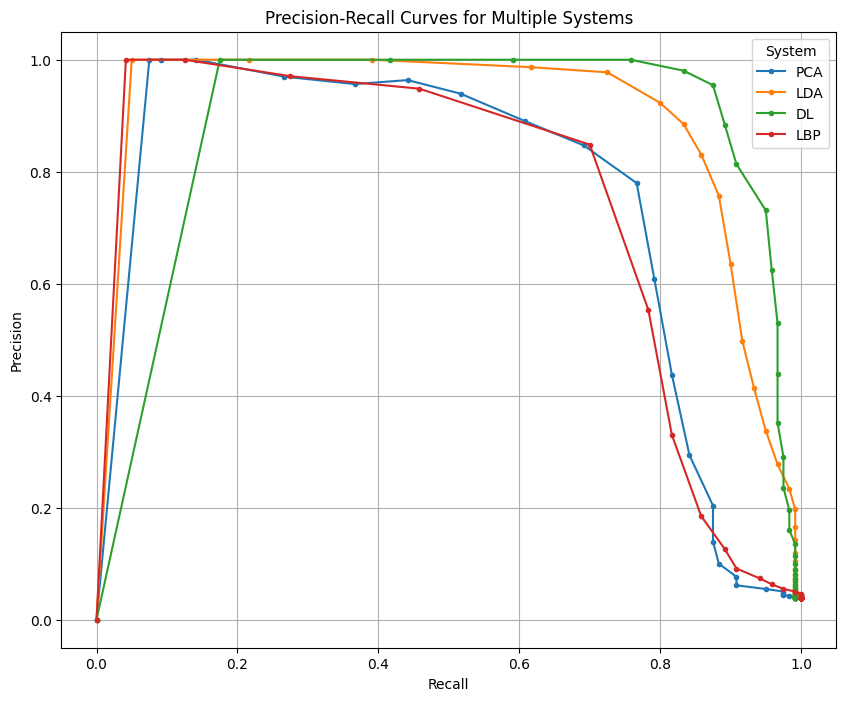

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of thresholds
thresholds = np.linspace(0, 1, 50)

# Names of the systems
systems = ['PCA', 'LDA', 'DL', 'LBP']  # Adjust these names to match your systems

# Prepare a dictionary to hold precision and recall values for each system
results = {system: {'precision': [], 'recall': []} for system in systems}

# Evaluate each system
for system in systems:
    distance_matrix = normalized_distance_matrices[system]

    # Iterate over each threshold
    for threshold in thresholds:
        total_TP = 0
        total_FP = 0
        total_FN = 0
        
        # Evaluate each row in the distance matrix
        for idx, (row_distances, reference_person) in enumerate(zip(distance_matrix, faces_verification.labels)):
            TP = 0
            FP = 0
            FN = 0
            unique_persons_checked = set()
            is_TP_found = False
            
            # Evaluate distances to count TP, FP
            for i, distance in enumerate(row_distances):
                current_person = faces_reference.labels[i]

                if distance < threshold:
                    if current_person == reference_person:
                        if not is_TP_found:
                            TP += 1
                            is_TP_found = True
                    else:
                        if current_person not in unique_persons_checked:
                            FP += 1
                            unique_persons_checked.add(current_person)
            
            if not is_TP_found:
                FN += 1
            
            total_TP += TP
            total_FP += FP
            total_FN += FN
        
        # Calculate precision and recall for this threshold
        if total_TP + total_FP > 0:
            results[system]['precision'].append(total_TP / (total_TP + total_FP))
        else:
            results[system]['precision'].append(0)
        
        if total_TP + total_FN > 0:
            results[system]['recall'].append(total_TP / (total_TP + total_FN))
        else:
            results[system]['recall'].append(0)

### Step 2: Plotting

# Setup the plot
plt.figure(figsize=(10, 8))

# Plot each system's PR curve
for system, values in results.items():
    plt.plot(values['recall'], values['precision'], marker='.', label=system)

# Adding plot details
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multiple Systems')
plt.legend(title='System')
plt.grid(True)

# Save the figure to the specified directory
plt.savefig('/kaggle/working/precision_recall_curves.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## FAR and FRR Curves with EER for Multiple Systems

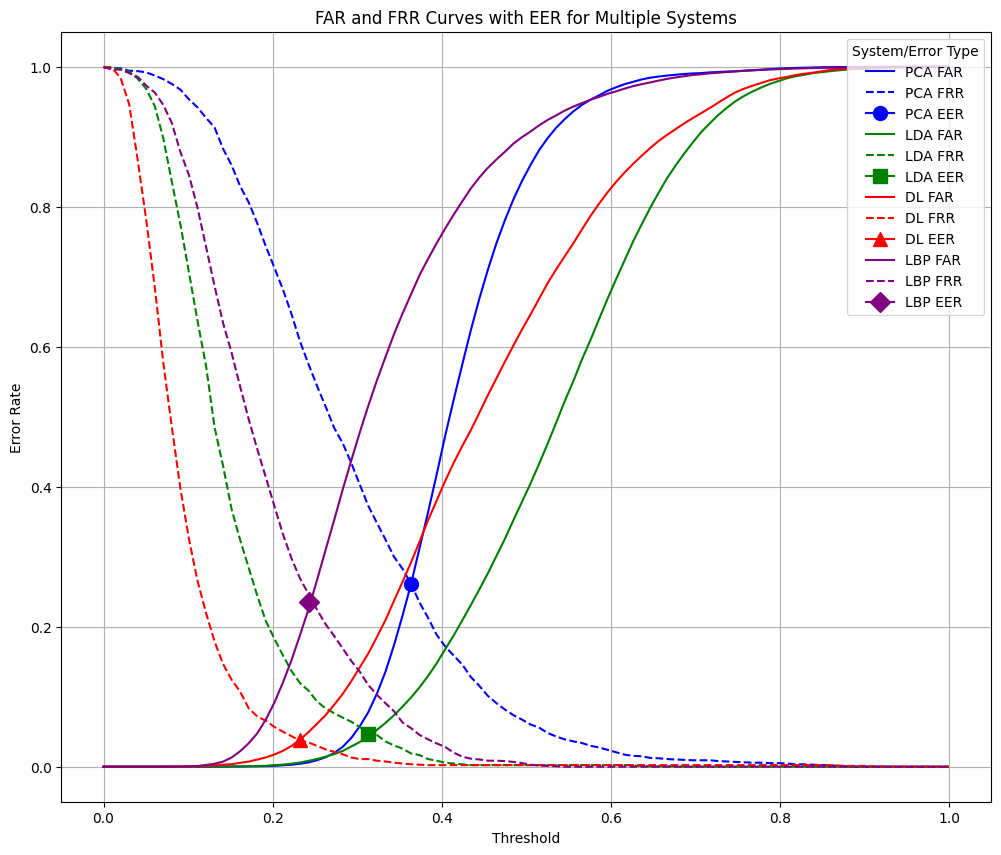

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of thresholds
thresholds = np.linspace(0, 1, 100)

# Names of the systems
systems = ['PCA', 'LDA', 'DL', 'LBP']  # Names adjusted to match your systems

# Color and marker settings for clarity
colors = ['blue', 'green', 'red', 'purple']
markers = ['o', 's', '^', 'D']  # Different marker for each system's EER point

# Prepare a dictionary to hold FAR, FRR, and EER values for each system
results = {system: {'FAR': [], 'FRR': [], 'EER': None, 'EER_idx': None} for system in systems}

# Evaluate each system
for system_idx, system in enumerate(systems):
    distance_matrix = normalized_distance_matrices[system]

    # Iterate over each threshold
    for threshold in thresholds:
        total_FA = 0
        total_FR = 0
        total_Genuine = 0
        total_Imposter = 0
        
        # Evaluate each row in the distance matrix
        for idx, (row_distances, reference_person) in enumerate(zip(distance_matrix, faces_verification.labels)):
            for i, distance in enumerate(row_distances):
                current_person = faces_reference.labels[i]

                if current_person == reference_person:
                    if distance > threshold:
                        total_FR += 1  # Genuine but rejected
                    total_Genuine += 1
                else:
                    if distance <= threshold:
                        total_FA += 1  # Imposter but accepted
                    total_Imposter += 1
        
        # Calculate FAR and FRR for this threshold
        FAR = total_FA / total_Imposter if total_Imposter else 0
        FRR = total_FR / total_Genuine if total_Genuine else 0
        
        results[system]['FAR'].append(FAR)
        results[system]['FRR'].append(FRR)

    # Find the EER point
    FAR_array = np.array(results[system]['FAR'])
    FRR_array = np.array(results[system]['FRR'])
    idx = np.nanargmin(np.abs(FAR_array - FRR_array))  # Index where FAR and FRR are closest
    results[system]['EER'] = (FAR_array[idx] + FRR_array[idx]) / 2  # Average the two rates at this index
    results[system]['EER_idx'] = idx

### Step 2: Plotting

# Setup the plot
plt.figure(figsize=(12, 10))

# Plot FAR and FRR curves for each system with distinct colors
for system_idx, (system, values) in enumerate(results.items()):
    plt.plot(thresholds, values['FAR'], label=f'{system} FAR', color=colors[system_idx])
    plt.plot(thresholds, values['FRR'], label=f'{system} FRR', linestyle='--', color=colors[system_idx])
    plt.plot(thresholds[values['EER_idx']], values['EER'], marker=markers[system_idx], color=colors[system_idx], markersize=10, label=f'{system} EER')

# Adding plot details
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('FAR and FRR Curves with EER for Multiple Systems')
plt.legend(loc='upper right', title='System/Error Type')
plt.grid(True)

# Display the plot
plt.show()


## CMC Curves

### 2.2. Validation as identification system

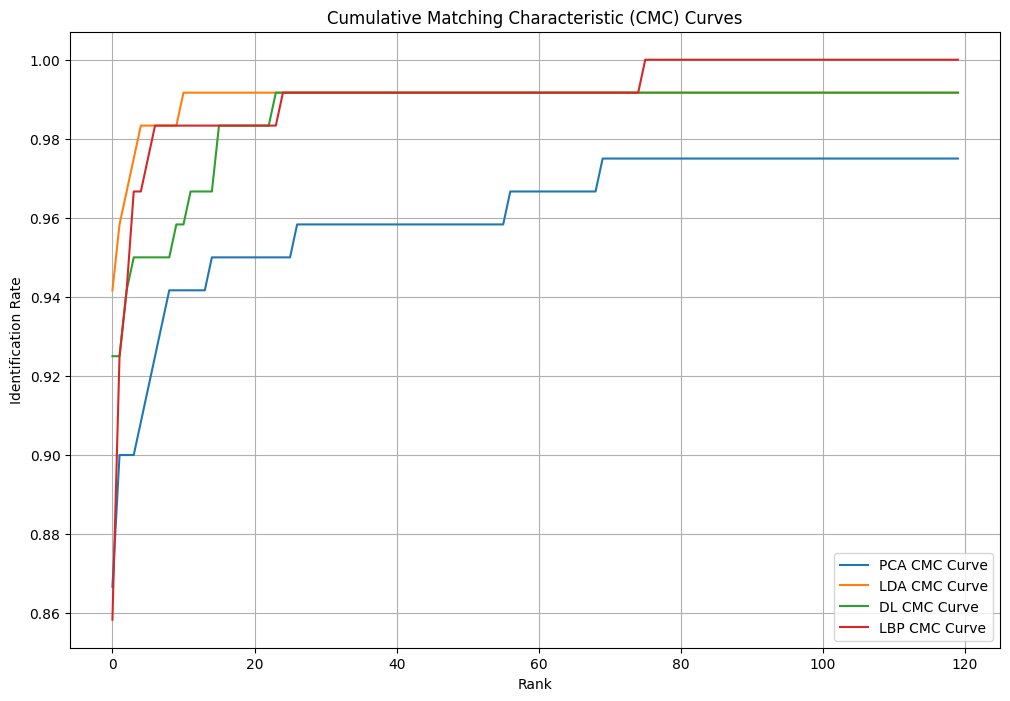

Rank-1 Performance for PCA: 0.8667
Rank-1 Performance for LDA: 0.9417
Rank-1 Performance for DL: 0.9250
Rank-1 Performance for LBP: 0.8583


In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform min-max normalization on a matrix
def min_max_normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val) if max_val > min_val else matrix

# Assuming distance matrices are already computed
normalized_distance_matrix_PCA = min_max_normalize_matrix(distance_matrix_PCA)
normalized_distance_matrix_LDA = min_max_normalize_matrix(distance_matrix_LDA)
normalized_distance_matrix_DL = min_max_normalize_matrix(distance_matrix_DL)
normalized_distance_matrix_LBP = min_max_normalize_matrix(distance_matrix_LBP)

# Function to compute CMC curve
def compute_cmc(distance_matrix, labels_reference, labels_verification):
    num_queries = distance_matrix.shape[0]
    cmc = np.zeros(num_queries)
    
    for i in range(num_queries):
        # Sort distances for the i-th query
        sorted_indices = np.argsort(distance_matrix[i, :])
        # Get the ranks of the correct matches
        correct_match_rank = np.where(labels_reference[sorted_indices] == labels_verification[i])[0][0]
        # Update CMC curve
        cmc[correct_match_rank:] += 1
    
    return cmc / num_queries

# Labels for reference and verification sets
labels_reference = faces_reference.labels
labels_verification = faces_verification.labels

# Compute CMC curves
cmc_pca = compute_cmc(normalized_distance_matrix_PCA, labels_reference, labels_verification)
cmc_lda = compute_cmc(normalized_distance_matrix_LDA, labels_reference, labels_verification)
cmc_dl = compute_cmc(normalized_distance_matrix_DL, labels_reference, labels_verification)
cmc_lbp = compute_cmc(normalized_distance_matrix_LBP, labels_reference, labels_verification)

# Plot the CMC curves
plt.figure(figsize=(12, 8))
plt.plot(cmc_pca, label='PCA CMC Curve')
plt.plot(cmc_lda, label='LDA CMC Curve')
plt.plot(cmc_dl, label='DL CMC Curve')
plt.plot(cmc_lbp, label='LBP CMC Curve')
plt.xlabel('Rank')
plt.ylabel('Identification Rate')
plt.title('Cumulative Matching Characteristic (CMC) Curves')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/cmc_curves_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

# Print Rank-1 performance for each method
rank1_performance_pca = cmc_pca[0]
rank1_performance_lda = cmc_lda[0]
rank1_performance_dl = cmc_dl[0]
rank1_performance_lbp = cmc_lbp[0]

print(f"Rank-1 Performance for PCA: {rank1_performance_pca:.4f}")
print(f"Rank-1 Performance for LDA: {rank1_performance_lda:.4f}")
print(f"Rank-1 Performance for DL: {rank1_performance_dl:.4f}")
print(f"Rank-1 Performance for LBP: {rank1_performance_lbp:.4f}")
